In [ ]:
#!pip3 install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 8.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 31.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 22.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
#!pip3 install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.0 MB/s eta 0:00:0000:010:01

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
#!pip3 install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 2.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# VGG + LSTM

In [ ]:
#############vgg

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import csv
from copy import copy
from collections import Counter
from collections import OrderedDict
import sys, time, os, warnings
import string
import tensorflow as tf
from keras.models import Sequential
import keras
from keras.applications import VGG16
from keras import models
from keras.preprocessing.image import load_img,  img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import ELU, PReLU, LeakyReLU
from time import time
from keras.callbacks import TensorBoard
from tensorflow.compat.v1.keras.backend import set_session
from nltk.translate.bleu_score import sentence_bleu

## VGG16

In [ ]:
vgg_mod = VGG16(include_top=True, weights=None)
vgg_mod.load_weights("/content/drive/MyDrive/course/FinalProject/data/vgg16_weights.h5")

In [ ]:
vgg_mod.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model = Sequential()
for layer in vgg_mod.layers[:-1]:
    model.add(layer)
vgg_model = models.Model(inputs=model.inputs, outputs=model.layers[-1].output)

In [ ]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## preprocess caption & image

In [ ]:
image_folder = "/content/drive/MyDrive/course/FinalProject/flickr/Flickr8k_Dataset"
txt_folder = "/content/drive/MyDrive/course/FinalProject/flickr/Flickr8k_text/Flickr8k.token.txt"
pic = os.listdir(image_folder)

In [ ]:
file = open(txt_folder,'r', encoding='utf8')
text = file.read()
file.close()

In [ ]:
datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

In [ ]:
text_df = pd.DataFrame(datatxt,columns=["filename","index","caption"])
unique_file = np.unique(text_df.filename.values)

In [ ]:
def df_word(text_df):
    vocabulary = []
    for txt in text_df.caption.values:
        vocabulary.extend(txt.split())
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({'word':list(ct.keys()), "count":list(ct.values())})
    dfword = dfword.sort_values("count", ascending=False)
    dfword = dfword.reset_index()[["word", "count"]]

    return (dfword)

In [ ]:
dfword = df_word(text_df)

In [ ]:
def punc(text_original):
    text_without_punct = text_original.translate(str.maketrans('','',string.punctuation))
    return text_without_punct

def char(text):
    text_len_greater_than_one = ""
    for word in text.split():
        if len(word) > 1:
            text_len_greater_than_one += " " + word
    return text_len_greater_than_one

def num_re(text, printTF=False):
    text_without_num = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("     {:10} : {:}".format(word, isalpha))
        if isalpha:
            text_without_num += " "+ word
    return text_without_num

In [ ]:
def clean_txt(text_original):
    text = punc(text_original)
    text = char(text)
    text = num_re(text)
    return text

In [ ]:
for i, caption in enumerate(text_df.caption.values):
    newcaption = clean_txt(caption)
    text_df['caption'].iloc[i] = newcaption

In [ ]:
def add_tokens(captions):
    caps = []
    for txt in captions:
        txt = "<start>" + txt + " <end>"
        caps.append(txt)
    return caps

In [ ]:
new_txt_df = copy(text_df)
new_txt_df["caption"] = add_tokens(text_df["caption"])

In [ ]:
new_txt_df.head()

filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  <start> child in pink dress is climbing up set...  
1      <start> girl going into wooden building <end>  
2  <start> little girl climbing into wooden playh...  
3  <start> little girl climbing the stairs to her...  
4  <start> little girl in pink dress going into w...

## feature extraction

In [ ]:
#feature extraction

In [ ]:
images = OrderedDict()
num_pix = 224
target_size = (num_pix, num_pix, 3)
data = np.zeros((len(pic), num_pix, num_pix, 3))

In [ ]:
for i, name in enumerate(pic):
    filename = image_folder + '/' + name
    image = load_img(filename, target_size=target_size)
    image = img_to_array(image)
    nimage = preprocess_input(image)
    y_pred = vgg_model.predict(nimage.reshape((1,)+ nimage.shape[:3]))
    images[name] = y_pred.flatten()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 18ms/step


In [ ]:
###### save as json

In [ ]:
with open('/content/drive/MyDrive/course/FinalProject/output_vgg/feat_extr.json', 'w') as f:
    f.write(json.dumps({k: v.tolist() for k, v in images.items()}))

In [ ]:
#read file

In [ ]:
# with open('/content/drive/MyDrive/course/FinalProject/output_vgg/feat_extr.json', 'r') as read_file:
#     a = {k: np.array(v) for k, v in json.loads(read_file.read()).items()}

## prepare training

In [ ]:
dimages, keepindex = [], []
new_txt_df = new_txt_df.loc[new_txt_df["index"].values == '0',:]

for i, fnm in enumerate(new_txt_df.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)

In [ ]:
fnames = new_txt_df["filename"].iloc[keepindex].values
dcaptions = new_txt_df["caption"] .iloc[keepindex].values
dimages = np.array(dimages)

## tokenizer

In [ ]:
tokenizer = Tokenizer(nb_words=6000)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
dtexts = tokenizer.texts_to_sequences(dcaptions)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


In [ ]:
#split test and train test

In [ ]:
prop_test, prop_val = 1000/8091, 1000/8091
N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

In [ ]:
def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest],
           dtexts[Ntest:Ntest+Nval],
           dtexts[Ntest+Nval:])

In [ ]:
dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [ ]:
#np.savetxt("/content/drive/MyDrive/course/FinalProject/output_vgg/fnm_test.txt", fnm_test, fmt='%s')

In [ ]:
#np.savetxt("/content/drive/MyDrive/course/FinalProject/output_vgg/fnm_train.txt", fnm_train, fmt='%s')

In [ ]:
#np.savetxt("/content/drive/MyDrive/course/FinalProject/output_vgg/fnm_val.txt", fnm_val, fmt='%s')

In [ ]:
maxlen = np.max([len(text) for text in dtexts])
minlen = np.min([len(text) for text in dtexts])

In [ ]:
def preprocessing(dtexts,dimages):
    N = len(dtexts)
    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    return(Xtext,Ximage,ytext)

In [ ]:
Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

## lstm

In [ ]:
#feature extractor model
input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256, activation='relu', name="ImageFeature")(input_image)

# LSTM sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size, 64, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256, name="CaptionFeature", return_sequences=True)(ftxt)
se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256, name="CaptionFeature2")(se2)

# decoder model
decoder = layers.add([ftxt, fimage])
decoder = layers.Dense(256, activation="relu")(decoder)
output = layers.Dense(vocab_size, activation='softmax')(decoder)

model = models.Model(inputs=[input_image, input_txt], outputs=output)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 64)               286336    ['input_4[0][0]']             
                                                                                                  
 CaptionFeature (LSTM)       (None, 30, 256)              328704    ['embedding[0][0]']           
                                                                                                  
 dropout (Dropout)           (None, 30, 256)              0         ['CaptionFeature[0][0]']      
                                                                                            

In [ ]:
tb = TensorBoard(log_dir="log/{}".format(time()))

In [ ]:
history = model.fit([Ximage_train, Xtext_train], ytext_train, epochs=10, verbose=2, batch_size=32, validation_data=([Ximage_val, Xtext_val], ytext_val), callbacks=[tb])

Epoch 1/10
1942/1942 - 333s - loss: 5.2298 - val_loss: 4.6787 - 333s/epoch - 171ms/step
Epoch 2/10
1942/1942 - 342s - loss: 4.3561 - val_loss: 4.4396 - 342s/epoch - 176ms/step
Epoch 3/10
1942/1942 - 334s - loss: 3.9769 - val_loss: 4.4053 - 334s/epoch - 172ms/step
Epoch 4/10
1942/1942 - 300s - loss: 3.7332 - val_loss: 4.4355 - 300s/epoch - 155ms/step
Epoch 5/10
1942/1942 - 300s - loss: 3.5432 - val_loss: 4.4950 - 300s/epoch - 154ms/step
Epoch 6/10
1942/1942 - 318s - loss: 3.3762 - val_loss: 4.5948 - 318s/epoch - 164ms/step
Epoch 7/10
1942/1942 - 299s - loss: 3.2343 - val_loss: 4.7277 - 299s/epoch - 154ms/step
Epoch 8/10
1942/1942 - 299s - loss: 3.1031 - val_loss: 4.8328 - 299s/epoch - 154ms/step
Epoch 9/10
1942/1942 - 301s - loss: 2.9834 - val_loss: 5.0499 - 301s/epoch - 155ms/step
Epoch 10/10
1942/1942 - 301s - loss: 2.8751 - val_loss: 5.1472 - 301s/epoch - 155ms/step


In [ ]:
model.save('/content/drive/MyDrive/course/FinalProject/output_vgg/vgg_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
##

In [ ]:
#from keras.models import load_model

In [ ]:
#test_load_modl = load_model('/content/drive/MyDrive/course/FinalProject/output_vgg/vgg_model.h5')

In [ ]:
#####

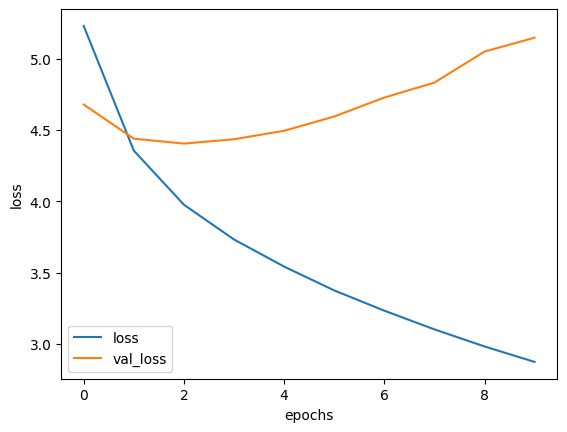

In [ ]:
for label in ["loss","val_loss"]:
    plt.plot(history.history[label], label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## evaluation - BLEU

In [ ]:
##generate caption and evlauate bleu score

In [ ]:
def predict_caption(image):
    in_text = '<start>'
    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " "+ newword
        if newword == "<end>":
            break
    return in_text

In [ ]:
index_word = dict([(index, word) for word, index in tokenizer.word_index.items()])
nkeep = 5
count = 0
bleus, output = [], []

In [ ]:
for jpgfnm, image_feature, tokenized_text in zip(fnm_test, di_test, dt_test):
    count += 1

    caption_true = [index_word[i] for i in tokenized_text]
    caption_true = caption_true[1:-1]

    caption = predict_caption(image_feature.reshape(1, len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]

    bleu = sentence_bleu([caption_true], caption)
    bleus.append(bleu)

    output.append((jpgfnm, caption))

In [ ]:
np.mean(bleus)

0.20312644050881537


## evaluation - bias

In [ ]:
########output predicted caption

In [ ]:
pred_imagelist=[]
pred_caption=[]
for item in output:
  my_lst_str = ' '.join(item[1])
  head, sep, tail = my_lst_str.partition('end')
  pred_imagelist.append(item[0])
  pred_caption.append(head)

In [ ]:
with open("/content/drive/MyDrive/course/FinalProject/output_vgg/caption_output.csv", "w") as infile:
    writer = csv.writer(infile)
    writer.writerow(["image", "caption"])
    for i in zip(pred_imagelist, pred_caption):
        writer.writerow(i)

In [ ]:
#########

In [ ]:
data_set = '/content/drive/MyDrive/course/FinalProject/flickr/'
captions_dir = data_set + "Flickr8k_text/"
test_images = '/content/drive/MyDrive/course/FinalProject/output_vgg/test_imagelist.txt'

In [ ]:
def load_all_captions(file_name):
    text_file = open(file_name, "r")
    lines = text_file.readlines()
    data_set = []
    for l in range(len(lines)):
        line = lines[l].strip()
        image_name = line[:line.find("#")]
        caption_number = line[line.find("#")+1:line.find("#")+2]
        caption = line[line.find("\t")+1:]
        data_set.append([image_name, caption_number, caption])
    return pd.DataFrame(data_set, columns =['image', 'caption#', 'caption'])

In [ ]:
captions_df = load_all_captions(captions_dir + "Flickr8k.token.txt")

In [ ]:
def load_test_image(file_name):
    text_file = open(file_name, "r")
    lines = text_file.readlines()
    data_set = []
    for l in range(len(lines)):
        line = lines[l].strip()
        data_set.append(line)
    return pd.DataFrame(data_set, columns =['image'])

In [ ]:
test_df = load_test_image(test_images)

In [ ]:
def get_ground_captions(test_df, captions_df):
    new_df = pd.DataFrame(columns = ['image', 'caption'])
    for i in tqdm(test_df.index):
        temp = captions_df[captions_df['image']==test_df.iloc[i]['image']]
        for j in range(5):
            new_df = pd.concat([new_df, pd.DataFrame([{'image': test_df.iloc[i]['image'], 'caption': temp.iloc[j]['caption']}])], ignore_index=True)
    return new_df

In [ ]:
test_captions_df = get_ground_captions(test_df, captions_df)

100%|██████████| 1000/1000 [00:09<00:00, 103.74it/s]


In [ ]:
test_captions_df.head(10)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

In [ ]:
pred_df = pd.read_csv('/content/drive/MyDrive/course/FinalProject/output_vgg/caption_output.csv')

In [ ]:
df_repeat = pred_df.loc[pred_df.index.repeat(5)]

In [ ]:
def add_tokens(captions):
    for i in range(len(captions)):
        caption = captions[i]
        caption = '<start> ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' <end>'
        captions[i] = caption
    return captions

In [ ]:
annotations= list(df_repeat['caption'])
annotations = add_tokens(annotations)
df_repeat['caption'] = annotations

In [ ]:
df_repeat[df_repeat['image'].str.contains("3234115903_f4dfc8fc75.jpg")==True]

image  \
1016  3234115903_f4dfc8fc75.jpg   
1017  3234115903_f4dfc8fc75.jpg   
1018  3234115903_f4dfc8fc75.jpg   
1019  3234115903_f4dfc8fc75.jpg   
1020  3234115903_f4dfc8fc75.jpg   

                                                caption  
1016  <start> a group of young men play basketball ....  
1017  <start> a group of young men play basketball ....  
1018  <start> a group of young men play basketball ....  
1019  <start> a group of young men play basketball ....  
1020  <start> a group of young men play basketball ....

In [ ]:
####

In [ ]:
def idetify_gender(sentence):
    male_words = ["male", "man", "boy", "gentleman", "guy"]
    female_words = ["female","woman", "girl", "lady"]
    male = False
    female = False
    for male_word in male_words:
        if sentence.find(male_word) > 0:
            male = True
    for female_word in female_words:
        if sentence.find(female_word) > 0:
            female = True
    if male and not female:
        return "male"
    elif female and not male:
        return "female"
    return "other"

In [ ]:
def gender_error(ground_truth, predicted):
    ground_truth_gender = ground_truth['caption'].apply(lambda x: idetify_gender(x))
    predicted_gender = predicted['caption'].apply(lambda x: idetify_gender(x))
    return confusion_matrix(ground_truth_gender, predicted_gender, labels=["male", "female", "other"])

In [ ]:
def gender_ratio(ground_truth, predicted):
    ground_truth_gender = ground_truth['caption'].apply(lambda x: idetify_gender(x))
    predicted_gender = predicted['caption'].apply(lambda x: idetify_gender(x))
    ground_truth_ratio = ground_truth_gender.value_counts()["female"]/ground_truth_gender.value_counts()["male"]
    predicted_ratio = predicted_gender.value_counts()["female"]/predicted_gender.value_counts()["male"]
    return (ground_truth_ratio, predicted_ratio)

In [ ]:
def object_gender_cooccurrence(ground_truth, predicted, object_name):
    gt_male_co = ground_truth['caption'].apply(lambda x: True if (idetify_gender(x)=="male" and x.find(object_name)>0) else False)
    gt_female_co =  ground_truth['caption'].apply(lambda x: True if (idetify_gender(x)=="female" and x.find(object_name)>0) else False)
    m1 = gt_male_co.value_counts()[True] if True in gt_male_co.value_counts() else 0
    f1 = gt_female_co.value_counts()[True] if True in gt_female_co.value_counts() else 0
    gt = (m1, f1)

    pred_male_co = predicted['caption'].apply(lambda x: True if (idetify_gender(x)=="male" and x.find(object_name)>0) else False)
    pred_female_co =  predicted['caption'].apply(lambda x: True if (idetify_gender(x)=="female" and x.find(object_name)>0) else False)
    m2 = pred_male_co.value_counts()[True] if True in pred_male_co.value_counts() else 0
    f2 = pred_female_co.value_counts()[True] if True in pred_female_co.value_counts() else 0
    pred = (m2, f2)

    return (gt, pred)

In [ ]:
def experiment(df, pred_df):

    cf_matrix = gender_error(df, pred_df)
    plt.figure(figsize = (7,5))
    ax = sns.heatmap(cf_matrix, annot=True, xticklabels = ["male", "female", "other"], yticklabels = ["male", "female", "other"])
    ax.set(title="Gender ratio",
      xlabel="Predicted",
      ylabel="Ground truth")
    plt.show()

    print("\n")

    gt, pred = gender_ratio(df, pred_df)
    print("Gender ratio of female to male:")
    print("Ground truth captions-> " + str(gt))
    print("Predicted captions->    " + str(pred))

    print("\n")

    words = ["bike"]
    for word in words:
        gt, pred = object_gender_cooccurrence(df, pred_df, word)
        #print(gt,pred)
        X = ["male", "female"]
        X_axis = np.arange(2)

        plt.bar(X_axis - 0.2, gt, 0.4, label = 'Ground truth')
        plt.bar(X_axis + 0.2, pred, 0.4, label = 'Predicted')

        plt.xticks(X_axis, X)
        plt.xlabel("Gender")
        plt.ylabel("co-occurrence with target word: \"" + word + "\"")
        plt.title("co-occurrence with \"" + word + "\" and male & female words")
        plt.legend()
        plt.show()

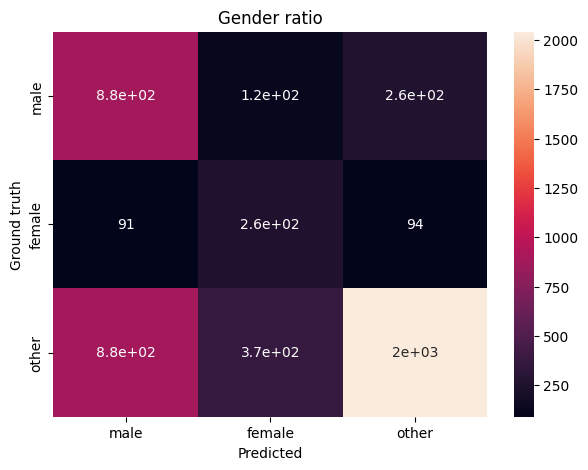



Gender ratio of female to male:
Ground truth captions-> 0.3499210110584518
Predicted captions->    0.40431266846361186




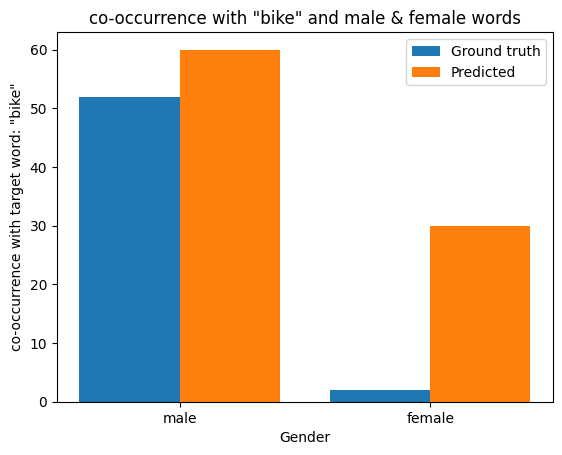

In [ ]:
experiment(test_captions_df, df_repeat)

In [ ]:
def test_experiment(df, pred_df):
    words = ["basketball", "soccer", "snowboard"]
    for word in words:
        gt, pred = object_gender_cooccurrence(df, pred_df, word)
        #print(gt,pred)
        X = ["male", "female"]
        X_axis = np.arange(2)

        plt.bar(X_axis - 0.2, gt, 0.4, label = 'Ground truth')
        plt.bar(X_axis + 0.2, pred, 0.4, label = 'Predicted')

        plt.xticks(X_axis, X)
        plt.xlabel("Gender")
        plt.ylabel("co-occurrence with target word: \"" + word + "\"")
        plt.title("co-occurrence with \"" + word + "\" and male & female words")
        plt.legend()
        plt.show()

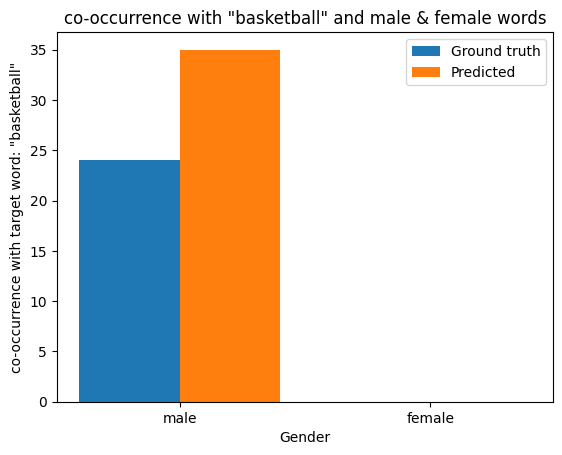

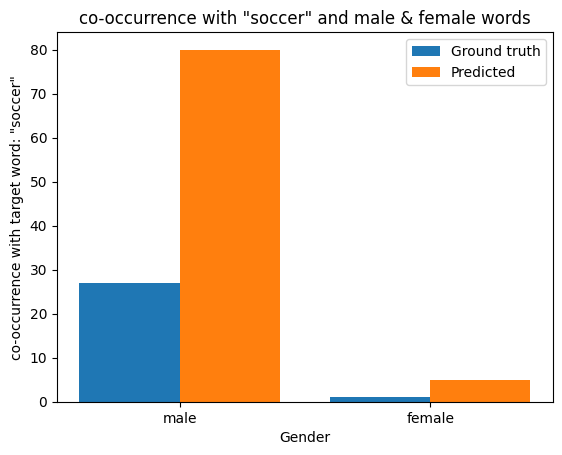

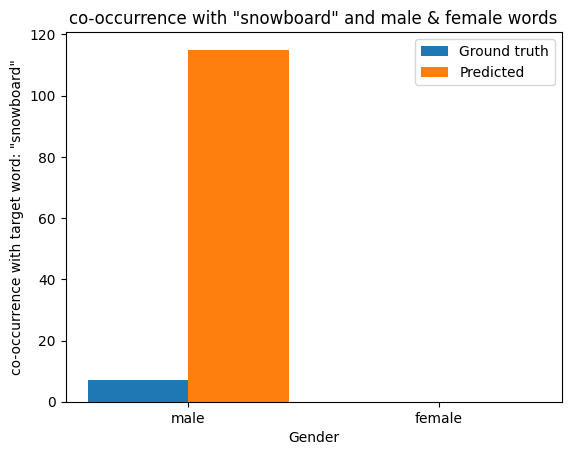

In [ ]:
test_experiment(test_captions_df, df_repeat)

# ResNet + LSTM

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pickle
from collections import Counter
import nltk
from PIL import Image
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import Subset
from torch.utils.data import random_split
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence
from torchtext.data.metrics import bleu_score
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#######################################

In [ ]:
def read_file(file_name, text_dir):
    with open(os.path.join(text_dir, file_name), 'rb') as files:
        lines = files.read().splitlines()
    return lines

In [ ]:
def map_imgs():
     img_cap_dict={}
     for caption in captions:
        caption = caption.decode("utf-8")
        image_name = caption.split('#')[0]
        image_caption = caption.split('#')[1].split('\t')[1]
        if image_name not in img_cap_dict.keys():
            img_cap_dict[image_name] = [image_caption]
     return img_cap_dict

In [ ]:
text_dir = '/content/drive/MyDrive/course/FinalProject/flickr/Flickr8k_text'
train_image_paths = read_file('Flickr_8k.trainImages.txt', text_dir)
test_image_paths = read_file('Flickr_8k.testImages.txt', text_dir)
captions = read_file('Flickr8k.token.txt', text_dir)
img_cap_dict=map_imgs()

In [ ]:
del img_cap_dict['2258277193_586949ec62.jpg.1']

## preprocess capation & image

In [ ]:
class Vocab(object):
    def __init__(self):
        self.w2i={}
        self.i2w={}
        self.index=0

    def __call__(self,token):
        if not token in self.w2i:
            return self.w2i['<ukn>']
        return self.w2i[token]

    def __len__(self):
        return len(self.w2i)

    def add_token(self,token):
        if token not in self.w2i:
            self.w2i[token]=self.index
            self.i2w[self.index]=token
            self.index+=1

def build_vocabulary(map):
    counter=Counter()
    ids=map.keys()
    for i,id in enumerate(ids):
        captions=map[id]
        for caption in captions:
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)
    tokens = [token for token, cnt in counter.items()]
    vocab = Vocab()
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab

In [ ]:
vocab = build_vocabulary(img_cap_dict)
vocab_path = '/content/drive/MyDrive/course/FinalProject/output/vocabulary.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

In [ ]:
def reshape_images(input_path, output_path, shape):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    images = os.listdir(input_path)
    num_im = len(images)

    for i, im in enumerate(images):
        with open(os.path.join(input_path, im), 'rb') as f:
            with Image.open(f) as image:
                image = image.resize(shape, Image.Resampling.LANCZOS)
                image.save(os.path.join(output_path, im), image.format)

In [ ]:
#dont run below if already resized images

input_path = '/content/drive/MyDrive/course/FinalProject/flickr/Flickr8k_Dataset/'
output_path = '/content/drive/MyDrive/course/FinalProject/output/resized_images/'
image_shape = [224, 224]
reshape_images(input_path, output_path, image_shape)

## data loader

In [ ]:
class Data_Loader(data.Dataset):
    def __init__(self,data_path,map, vocabulary,transform=None):
        self.root = data_path
        self.indices = list(map.keys())
        self.vocabulary = vocabulary
        self.transform = transform
        self.map=map

    def __getitem__(self, idx):
        vocabulary = self.vocabulary
        id = self.indices[idx]
        captions = self.map[id]
         #convert image to tensor and pre-process using transform
        image = Image.open(os.path.join(self.root,id)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        caption = []
        caption.append(vocabulary('<start>'))
          #convert caption to tensor of word ids.
        for cap in captions:
            word_tokens = nltk.tokenize.word_tokenize(str(cap).lower())
            caption.extend([vocabulary(token) for token in word_tokens])

        caption.append(vocabulary('<end>'))
        image_caption = torch.Tensor(caption)
        #return pre-processed image and caption tensors
        return image,image_caption

    def __len__(self):
        return len(self.indices)
def collate_function(data_batch):
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    imgs, caps = zip(*data_batch)
    imgs = torch.stack(imgs, 0)
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long()
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = cap[:end]
    return imgs, tgts, cap_lens

#return data loader
def get_loader(data_path, map, vocabulary, transform, batch_size, shuffle, num_workers):
    flicker_dataset = Data_Loader(data_path=data_path,map=map,vocabulary=vocabulary,transform=transform)
    train_ds, test_ds = random_split(flicker_dataset, [7091,1000])
    train_data_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size,shuffle=shuffle,num_workers=num_workers,collate_fn=collate_function)
    test_data_loader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=1,shuffle=shuffle,num_workers=num_workers,collate_fn=collate_function)
    return train_data_loader,test_data_loader

## ResNet152

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        super(CNNModel, self).__init__()
        resnet = models.resnet152(pretrained=True)
        module_list = list(resnet.children())[:-1]
        self.resnet_module = nn.Sequential(*module_list)
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)

    def forward(self, input_images):
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)
        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        return final_features

## LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len

    def forward(self, input_features, capts, lens):
        embeddings = self.embedding_layer(caps)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True)
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs

    def sample(self, input_features, lstm_states=None):
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))
            _, predicted_outputs = model_outputs.max(1)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)
            lstm_inputs = lstm_inputs.unsqueeze(1)
        sampled_indices = torch.stack(sampled_indices, 1)
        return sampled_indices

## train model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
with open('/content/drive/MyDrive/course/FinalProject/output/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

In [ ]:
train_data_loader,test_data_loader = get_loader('/content/drive/MyDrive/course/FinalProject/output/resized_images/', img_cap_dict, vocabulary, transform, 128,shuffle=True, num_workers=0)
encoder_model = CNNModel(512).to(device)
decoder_model = LSTMModel(512, 512, len(vocabulary), 1).to(device)
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 113MB/s]


In [ ]:
total_num_steps = len(train_data_loader)
for epoch in range(10):
    for i, (imgs, caps, lens) in enumerate(train_data_loader):
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]
        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = loss_criterion(outputs, tgts)
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, 10, i, total_num_steps, loss.item()))

Epoch [0/10], Step [0/56], Loss: 8.4184
Epoch [0/10], Step [10/56], Loss: 5.0927
Epoch [0/10], Step [20/56], Loss: 4.4413
Epoch [0/10], Step [30/56], Loss: 4.1336
Epoch [0/10], Step [40/56], Loss: 3.8048
Epoch [0/10], Step [50/56], Loss: 3.9619
Epoch [1/10], Step [0/56], Loss: 3.4213
Epoch [1/10], Step [10/56], Loss: 3.4637
Epoch [1/10], Step [20/56], Loss: 3.3230
Epoch [1/10], Step [30/56], Loss: 3.3801
Epoch [1/10], Step [40/56], Loss: 3.3651
Epoch [1/10], Step [50/56], Loss: 3.1565
Epoch [2/10], Step [0/56], Loss: 3.0928
Epoch [2/10], Step [10/56], Loss: 3.0621
Epoch [2/10], Step [20/56], Loss: 3.0250
Epoch [2/10], Step [30/56], Loss: 2.9631
Epoch [2/10], Step [40/56], Loss: 2.7632
Epoch [2/10], Step [50/56], Loss: 3.0995
Epoch [3/10], Step [0/56], Loss: 2.6894
Epoch [3/10], Step [10/56], Loss: 2.8091
Epoch [3/10], Step [20/56], Loss: 2.8069
Epoch [3/10], Step [30/56], Loss: 2.7650
Epoch [3/10], Step [40/56], Loss: 2.8458
Epoch [3/10], Step [50/56], Loss: 2.6715
Epoch [4/10], Step [

In [ ]:
torch.save(decoder_model.state_dict(), os.path.join('/content/drive/MyDrive/course/FinalProject/output/models_10/', 'decoder-{}.ckpt'.format(epoch+1)))
torch.save(encoder_model.state_dict(), os.path.join('/content/drive/MyDrive/course/FinalProject/output/models_10/', 'encoder-{}.ckpt'.format(epoch+1)))

## evaluation - BLEU

In [ ]:
with open('/content/drive/MyDrive/course/FinalProject/output/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

In [ ]:
encoder_model = CNNModel(512).eval()
decoder_model = LSTMModel(512, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)

In [ ]:
encoder_model.load_state_dict(torch.load('/content/drive/MyDrive/course/FinalProject/output/models_10/encoder-10.ckpt'))
decoder_model.load_state_dict(torch.load('/content/drive/MyDrive/course/FinalProject/output/models_10/decoder-10.ckpt'))

<All keys matched successfully>

In [ ]:
candidate_corpus=[]
reference_corpus=[]

In [ ]:
for i, (imgs, caps, lens) in enumerate(test_data_loader):
    imgs = imgs.to(device)
    feat = encoder_model(imgs)
    sampled_indices = decoder_model.sample(feat)
    sampled_indices = sampled_indices.cpu().numpy()
    caps=caps.numpy()
    predicted_caption = []
    target_caption=[]
    for token_index in sampled_indices:
        for tokens in token_index:
            word = vocabulary.i2w[tokens]
            if word=='<unk>':
                continue
            if word=='<end>':
                continue
            if word == '<start>':
                continue
            if word== '.' :
                continue
            predicted_caption.append(word)
    for token_index in caps:
        for tokens in token_index:
            word = vocabulary.i2w[tokens]
            if word=='<unk>':
                continue
            if word=='<end>':
                continue
            if word == '<start>':
                continue
            if word== '.' :
                continue
            target_caption.append(word)

    candidate_corpus.append(predicted_caption)
    reference_corpus.append([target_caption])

In [ ]:
print(bleu_score(candidate_corpus, reference_corpus))

0.0608271025121212


In [ ]:
###### output prediction

In [ ]:
def predict_caption(image_file_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def load_image(image_file_path, transform=None):
        img = Image.open(image_file_path).convert('RGB')
        img = img.resize([224, 224], Image.LANCZOS)

        if transform is not None:
            img = transform(img).unsqueeze(0)

        return img

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

    with open('/content/drive/MyDrive/course/FinalProject/output/vocabulary.pkl', 'rb') as f:
        vocabulary = pickle.load(f)

    encoder_model = CNNModel(512).eval()
    decoder_model = LSTMModel(512, 512, len(vocabulary), 1)
    encoder_model = encoder_model.to(device)
    decoder_model = decoder_model.to(device)

    encoder_model.load_state_dict(torch.load('/content/drive/MyDrive/course/FinalProject/output/models_10/encoder-10.ckpt'))
    decoder_model.load_state_dict(torch.load('/content/drive/MyDrive/course/FinalProject/output/models_10/decoder-10.ckpt'))

    img = load_image(image_file_path, transform)
    img_tensor = img.to(device)

    feat = encoder_model(img_tensor)
    sampled_indices = decoder_model.sample(feat)
    sampled_indices = sampled_indices[0].cpu().numpy()
    predicted_caption = []
    for token_index in sampled_indices:
        word = vocabulary.i2w[token_index]
        predicted_caption.append(word)
        if word == '<end>':
            break
    predicted_sentence = ' '.join(predicted_caption)

    return predicted_sentence

In [ ]:
def predict_captions(df):
    output_file = open("/content/drive/MyDrive/course/FinalProject/output/output_captions_10.txt", "w")
    output_file.write("image,caption\n")
    for i in tqdm(df.index):
        img_file = df['image'][i]
        pred_caption = predict_caption('/content/drive/MyDrive/course/FinalProject/flickr/Flickr8k_Dataset/' + img_file)
        output_file.write(img_file + "," + pred_caption + "\n")
    output_file.close()

In [ ]:
########

In [ ]:
data_set = '/content/drive/MyDrive/course/FinalProject/flickr/'
captions_dir = data_set + "Flickr8k_text/"
train_images = captions_dir + 'Flickr_8k.trainImages.txt'
test_images = captions_dir + 'Flickr_8k.testImages.txt'

In [ ]:
def load_all_captions(file_name):
    text_file = open(file_name, "r")
    lines = text_file.readlines()
    data_set = []
    for l in range(len(lines)):
        line = lines[l].strip()
        image_name = line[:line.find("#")]
        caption_number = line[line.find("#")+1:line.find("#")+2]
        caption = line[line.find("\t")+1:]
        data_set.append([image_name, caption_number, caption])
    return pd.DataFrame(data_set, columns =['image', 'caption#', 'caption'])

In [ ]:
captions_df = load_all_captions(captions_dir + "Flickr8k.token.txt")

In [ ]:
def load_test_image(file_name):
    text_file = open(file_name, "r")
    lines = text_file.readlines()
    data_set = []
    for l in range(len(lines)):
        line = lines[l].strip()
        data_set.append(line)
    return pd.DataFrame(data_set, columns =['image'])

In [ ]:
test_df = load_test_image(test_images)

In [ ]:
def get_ground_captions(test_df, captions_df):
    new_df = pd.DataFrame(columns = ['image', 'caption'])
    for i in tqdm(test_df.index):
        temp = captions_df[captions_df['image']==test_df.iloc[i]['image']]
        for j in range(5):
            new_df = pd.concat([new_df, pd.DataFrame([{'image': test_df.iloc[i]['image'], 'caption': temp.iloc[j]['caption']}])], ignore_index=True)
    return new_df

In [ ]:
test_captions_df = get_ground_captions(test_df, captions_df)

100%|██████████| 1000/1000 [00:07<00:00, 131.84it/s]


In [ ]:
test_captions_df.head(10)

image  \
0  3385593926_d3e9c21170.jpg   
1  3385593926_d3e9c21170.jpg   
2  3385593926_d3e9c21170.jpg   
3  3385593926_d3e9c21170.jpg   
4  3385593926_d3e9c21170.jpg   
5  2677656448_6b7e7702af.jpg   
6  2677656448_6b7e7702af.jpg   
7  2677656448_6b7e7702af.jpg   
8  2677656448_6b7e7702af.jpg   
9  2677656448_6b7e7702af.jpg   

                                             caption  
0     The dogs are in the snow in front of a fence .  
1                        The dogs play on the snow .  
2       Two brown dogs playfully fight in the snow .  
3               Two brown dogs wrestle in the snow .  
4                     Two dogs playing in the snow .  
5  a brown and white dog swimming towards some in...  
6  A dog in a swimming pool swims toward sombody ...  
7              A dog swims in a pool near a person .  
8  Small dog is paddling through the water in a p...  
9     The small brown and white dog is in the pool .

In [ ]:
predict_captions(test_captions_df)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 5000/5000 [2:54:01<00:00,  2.09s/it]


## evaluation - bias

In [ ]:
#### bias

In [ ]:
test_captions_df[test_captions_df['image'].str.contains("3234115903_f4dfc8fc75.jpg")==True]

image  \
1015  3234115903_f4dfc8fc75.jpg   
1016  3234115903_f4dfc8fc75.jpg   
1017  3234115903_f4dfc8fc75.jpg   
1018  3234115903_f4dfc8fc75.jpg   
1019  3234115903_f4dfc8fc75.jpg   

                                                caption  
1015  A female hockey player in blue is challenging ...  
1016  Two girls are fighting for the ball in indoor ...  
1017  Two women with blue and white uniforms playing...  
1018  Two young female floor hockey players fight ov...  
1019  Women playing a game similar to hockey , but w...

In [ ]:
pred_df = pd.read_csv('/content/drive/MyDrive/course/FinalProject/output/output_captions_10.txt')

In [ ]:
pred_df[pred_df['caption'].str.contains("girl")==True]

image  \
30    2339106348_2df90aa6a9.jpg   
31    2339106348_2df90aa6a9.jpg   
32    2339106348_2df90aa6a9.jpg   
33    2339106348_2df90aa6a9.jpg   
34    2339106348_2df90aa6a9.jpg   
...                         ...   
4975  3727752439_907795603b.jpg   
4976  3727752439_907795603b.jpg   
4977  3727752439_907795603b.jpg   
4978  3727752439_907795603b.jpg   
4979  3727752439_907795603b.jpg   

                                                caption  
30    <start> a girl in a pink dress is walking past...  
31    <start> a girl in a pink dress is walking past...  
32    <start> a girl in a pink dress is walking past...  
33    <start> a girl in a pink dress is walking past...  
34    <start> a girl in a pink dress is walking past...  
...                                                 ...  
4975  <start> a girl in a pink dress is walking on a...  
4976  <start> a girl in a pink dress is walking on a...  
4977  <start> a girl in a pink dress is walking on a...  
4978  <start> a girl in a pink dress is walking on a...  
4979  <start> a girl in a pink dress is walking on a...  

[630 rows x 2 columns]

In [ ]:
def idetify_gender(sentence):
    male_words = ["male", "man", "boy", "gentleman", "guy"]
    female_words = ["female","woman", "girl", "lady"]
    male = False
    female = False
    for male_word in male_words:
        if sentence.find(male_word) > 0:
            male = True
    for female_word in female_words:
        if sentence.find(female_word) > 0:
            female = True
    if male and not female:
        return "male"
    elif female and not male:
        return "female"
    return "other"

In [ ]:
def gender_error(ground_truth, predicted):
    ground_truth_gender = ground_truth['caption'].apply(lambda x: idetify_gender(x))
    predicted_gender = predicted['caption'].apply(lambda x: idetify_gender(x))
    return confusion_matrix(ground_truth_gender, predicted_gender, labels=["male", "female", "other"])

In [ ]:
def gender_ratio(ground_truth, predicted):
    ground_truth_gender = ground_truth['caption'].apply(lambda x: idetify_gender(x))
    predicted_gender = predicted['caption'].apply(lambda x: idetify_gender(x))
    ground_truth_ratio = ground_truth_gender.value_counts()["female"]/ground_truth_gender.value_counts()["male"]
    predicted_ratio = predicted_gender.value_counts()["female"]/predicted_gender.value_counts()["male"]
    return (ground_truth_ratio, predicted_ratio)

In [ ]:
def object_gender_cooccurrence(ground_truth, predicted, object_name):
    gt_male_co = ground_truth['caption'].apply(lambda x: True if (idetify_gender(x)=="male" and x.find(object_name)>0) else False)
    gt_female_co =  ground_truth['caption'].apply(lambda x: True if (idetify_gender(x)=="female" and x.find(object_name)>0) else False)
    m1 = gt_male_co.value_counts()[True] if True in gt_male_co.value_counts() else 0
    f1 = gt_female_co.value_counts()[True] if True in gt_female_co.value_counts() else 0
    gt = (m1, f1)

    pred_male_co = predicted['caption'].apply(lambda x: True if (idetify_gender(x)=="male" and x.find(object_name)>0) else False)
    pred_female_co =  predicted['caption'].apply(lambda x: True if (idetify_gender(x)=="female" and x.find(object_name)>0) else False)
    m2 = pred_male_co.value_counts()[True] if True in pred_male_co.value_counts() else 0
    f2 = pred_female_co.value_counts()[True] if True in pred_female_co.value_counts() else 0
    pred = (m2, f2)

    return (gt, pred)

In [ ]:
def experiment(df, pred_df):

    cf_matrix = gender_error(df, pred_df)
    plt.figure(figsize = (7,5))
    ax = sns.heatmap(cf_matrix, annot=True, xticklabels = ["male", "female", "other"], yticklabels = ["male", "female", "other"])
    ax.set(title="Gender ratio",
      xlabel="Predicted",
      ylabel="Ground truth")
    plt.show()

    print("\n")

    gt, pred = gender_ratio(df, pred_df)
    print("Gender ratio of female to male:")
    print("Ground truth captions-> " + str(gt))
    print("Predicted captions->    " + str(pred))

    print("\n")

    words = ["bike"]
    for word in words:
        gt, pred = object_gender_cooccurrence(df, pred_df, word)
        X = ["male", "female"]
        X_axis = np.arange(2)
        plt.bar(X_axis - 0.2, gt, 0.4, label = 'Ground truth')
        plt.bar(X_axis + 0.2, pred, 0.4, label = 'Predicted')
        plt.xticks(X_axis, X)
        plt.xlabel("Gender")
        plt.ylabel("co-occurrence with target word: \"" + word + "\"")
        plt.title("co-occurrence with \"" + word + "\" and male & female words")
        plt.legend()
        plt.show()

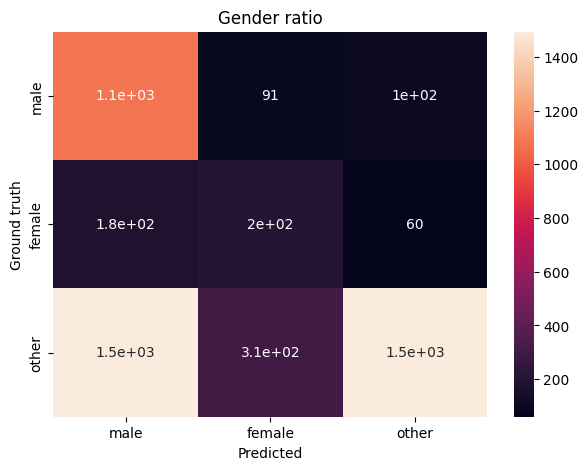



Gender ratio of female to male:
Ground truth captions-> 0.3499210110584518
Predicted captions->    0.21818181818181817




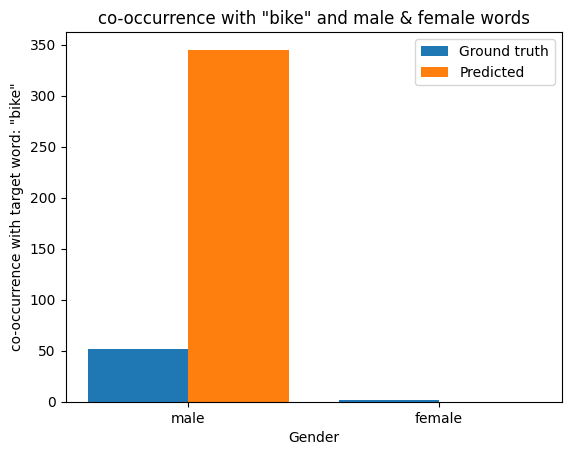

In [ ]:
experiment(test_captions_df, pred_df)

In [ ]:
def test_experiment(df, pred_df):
    words = ["basketball", "soccer", "snowboard"]
    for word in words:
        gt, pred = object_gender_cooccurrence(df, pred_df, word)
        X = ["male", "female"]
        X_axis = np.arange(2)
        plt.bar(X_axis - 0.2, gt, 0.4, label = 'Ground truth')
        plt.bar(X_axis + 0.2, pred, 0.4, label = 'Predicted')
        plt.xticks(X_axis, X)
        plt.xlabel("Gender")
        plt.ylabel("co-occurrence with target word: \"" + word + "\"")
        plt.title("co-occurrence with \"" + word + "\" and male & female words")
        plt.legend()
        plt.show()

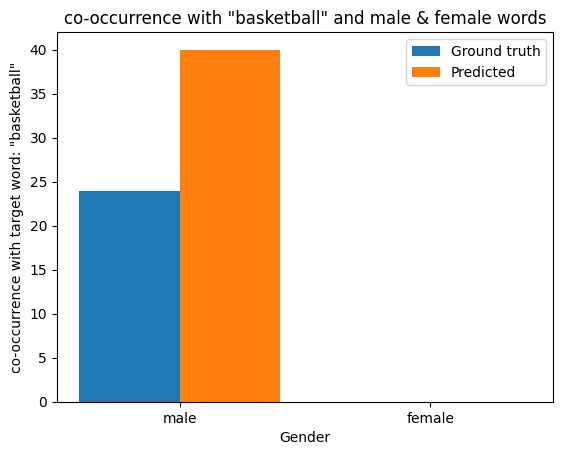

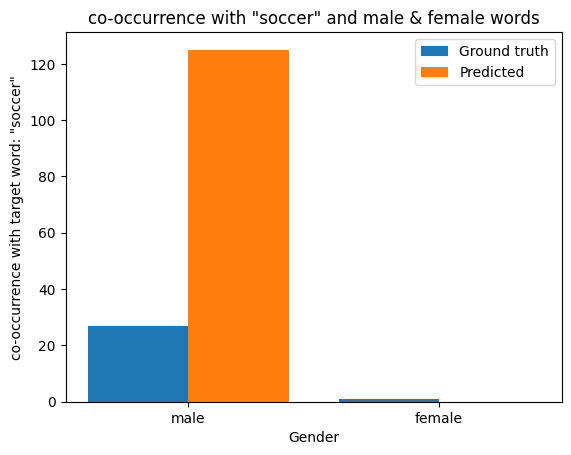

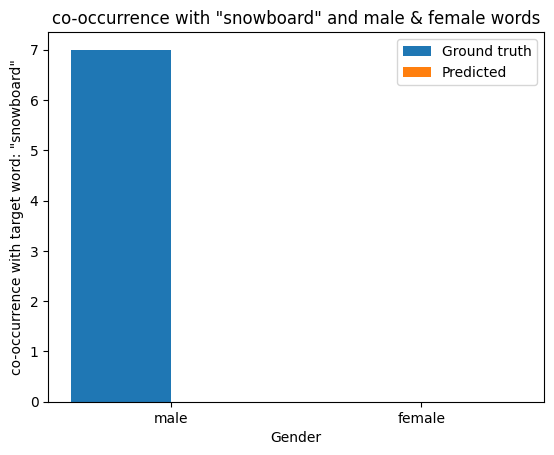

In [ ]:
test_experiment(test_captions_df, pred_df)

# Inception + Attention + GRU

In [ ]:
import numpy as np
import pandas as pd
import os
import csv
import glob
import copy
import spacy
import pickle
from PIL import Image
import random as rd
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu
from torchtext.data.metrics import bleu_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
####

In [ ]:
images='/Users/username/Desktop/flickr/Flickr8k_Dataset'
all_imgs = glob.glob(images + '/*.jpg',recursive=True)

In [ ]:
def load_doc(filename):
    try:
        with open(filename, 'r') as file:
            next(file)
            captions_doc = file.read()
        return captions_doc
    except FileNotFoundError:
        print(f"File '{filename}' not found.")
        return None

In [ ]:
file_path = '/Users/username/Desktop/train_data.txt'
doc = load_doc(file_path)

In [ ]:
mapping = {}
img_id_list = []
image_path_list = []
caption_list = []

In [ ]:
for line in tqdm(doc.split("\n")):
    tokens = line.split(',')
    if len(line)<2:
        continue

    img_id , caption = tokens[0] , tokens[1:]
    image_path_list.append('/Users/username/Desktop/flickr/Flickr8k_Dataset/' + img_id)

    img_id = img_id.split('.')[0]
    img_id_list.append(img_id)
    caption_list.append(caption)

    caption = " ".join(caption)

    if img_id not in mapping:
        mapping[img_id] = []

    mapping[img_id].append(caption)

  0%|          | 0/30001 [00:00<?, ?it/s]

In [ ]:
all_img_id= img_id_list
all_img_vector= image_path_list
annotations= caption_list
df = pd.DataFrame(list(zip(all_img_id, all_img_vector, annotations)),columns =['image','path', 'caption'])

In [ ]:
df['caption'] = df['caption'].apply(lambda x: ' '.join(x))

In [ ]:
def add_tokens(captions):
    for i in range(len(captions)):
        caption = captions[i]
        caption = '<start> ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' <end>'
        captions[i] = caption
    return captions

In [ ]:
annotations= list(df['caption'])
annotations = add_tokens(annotations)
all_img_path = image_path_list

In [ ]:
df['caption'] = annotations

## preprocess caption

In [ ]:
vocabulary= [word for sentence in annotations for word in sentence.split()]
val_count=Counter(vocabulary)

In [ ]:
top_word_count = 5000
filter_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count,
                                                  oov_token="<unk>",
                                                  filters=filter_chars)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [ ]:
word_index = tokenizer.word_index
index_word = tokenizer.index_word

In [ ]:
# Add pad Token
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
with open('/Users/username/Desktop/output_att/tokenizer.pkl',"wb") as f:
    pickle.dump(tokenizer,f)

In [ ]:
max_sequence_len = max(len(t) for t in train_seqs)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_sequence_len)

## preprocess image

In [ ]:
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
unique_img_vector = sorted (set(all_img_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(unique_img_vector)
image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                .batch(64)

In [ ]:
image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

## InceptionV3

In [ ]:
image_model = InceptionV3(include_top=False, weights=None)
image_model.load_weights("/Users/username/Desktop/inception_v3_weights.h5")
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
incepV3_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
for img, path in tqdm(image_dataset):
    batch_features = incepV3_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

  0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
#split dataset

In [ ]:
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector, cap_vector, test_size=0.1, random_state=42)

In [ ]:
#retrieve stored features and convert them into a TensorFlow dataset
#and returning the image tensor along with its caption

def map_func(image, caption):
    img_tensor = np.load(image.decode('utf-8')+'.npy')
    return img_tensor,caption

In [ ]:
def gen_dataset(image, caption, batch_size = 32, buffer_size=1000):

    dataset = tf.data.Dataset.from_tensor_slices((image, caption))

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [ ]:
BATCH_SIZE = 64
train_dataset = gen_dataset(path_train, cap_train, BATCH_SIZE)
test_dataset = gen_dataset(path_test, cap_test, BATCH_SIZE)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))

In [ ]:
#The output shape of the image features in the dataset is (64, 64, 2048)
#with a batch size of 64

In [ ]:
embedding_dim = 256
units = 512
vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

## Encoder

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim = 256):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)

    def call(self, features):
        features =  self.dense(features)
        features = tf.nn.relu(features)
        return features

In [ ]:
encoder = Encoder(embedding_dim)

## Attention

In [ ]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis =  tf.expand_dims(hidden,1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                            self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)
        attention_weights =  tf.nn.softmax(score, axis=1)
        context_vector =  attention_weights * features
        context_vector =  tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## Decoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)
        self.d2 = tf.keras.layers.Dense(vocab_size)

    def call(self, x, features, hidden):

        context_vector, attention_weights = self.attention(features, hidden)
        embed =  self.embed(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed)

        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))
        output = self.d2(output)
        return output, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)
hidden = decoder.init_state(batch_size = sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)
predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
#masked loss function

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = os.path.join("/Users/username/Desktop/output_att/","checkpt")

In [ ]:
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)

In [ ]:
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
# teacher forcing

In [ ]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [ ]:
with strategy.scope():
    @tf.function
    def train_step(img_tensor, target):
        loss = 0
        hidden = decoder.init_state(batch_size=target.shape[0])
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

        with tf.GradientTape() as tape:
            features = encoder(img_tensor)
            for i in range(1,target.shape[1]):
                predictions,hidden,_ = decoder(dec_input, features, hidden)
                loss += loss_function(target[:,i], predictions)
                dec_input = tf.expand_dims(target[:, i], 1)

            avg_loss = (loss / int(target.shape[1]))
            trainable_variables = encoder.trainable_variables + decoder.trainable_variables
            gradients = tape.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, avg_loss

In [ ]:
with strategy.scope():
    @tf.function
    def test_step(img_tensor, target):
        loss = 0
        hidden = decoder.init_state(batch_size=target.shape[0])
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

        with tf.GradientTape() as tape:
            features = encoder(img_tensor)
            for i in range(1,target.shape[1]):
                predictions,hidden,_ = decoder(dec_input,features,hidden)
                loss += loss_function(target[:,i], predictions)
                predicted_id = tf.argmax(predictions,1)
                dec_input = tf.expand_dims(predicted_id, 1)

        avg_loss = (loss / int(target.shape[1]))

        return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch,(img_tensor,target)) in enumerate(test_dataset):
        batch_loss,t_loss = test_step(img_tensor,target)
        total_loss += t_loss
    return total_loss/test_num_steps

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 10
best_test_loss=100

## train model

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('epoch - {}, train loss - {:.3f}, test loss - {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('time: {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('testloss reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/10 [00:00<?, ?it/s]

epoch - 1, train loss - 1.384, test loss - 1.934
time: 2194.1780977249146 sec

testloss reduced from 100.000 to 1.934
epoch - 2, train loss - 1.078, test loss - 1.896
time: 1680.4912168979645 sec

testloss reduced from 1.934 to 1.896
epoch - 3, train loss - 0.971, test loss - 1.880
time: 1597.9784219264984 sec

testloss reduced from 1.896 to 1.880
epoch - 4, train loss - 0.897, test loss - 1.913
time: 1317.3339998722076 sec

epoch - 5, train loss - 0.838, test loss - 1.878
time: 1289.0890130996704 sec

testloss reduced from 1.880 to 1.878
epoch - 6, train loss - 0.786, test loss - 1.915
time: 1295.7368631362915 sec

epoch - 7, train loss - 0.739, test loss - 1.964
time: 1099.3910467624664 sec

epoch - 8, train loss - 0.698, test loss - 1.990
time: 1082.2754743099213 sec

epoch - 9, train loss - 0.660, test loss - 2.047
time: 1090.0865981578827 sec

epoch - 10, train loss - 0.622, test loss - 2.131
time: 1085.617744922638 sec



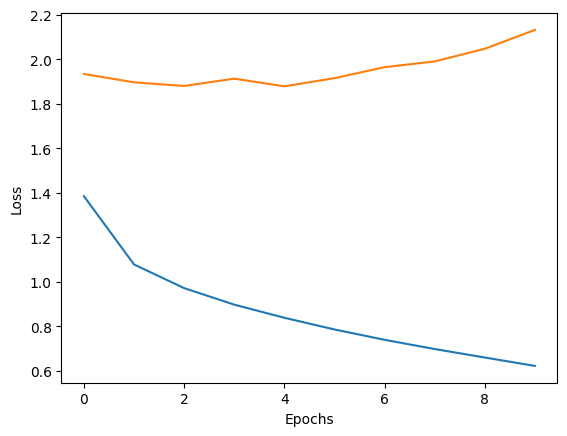

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
encoder.save_weights('/Users/username/Desktop/output_att/outputs_encoder')
decoder.save_weights('/Users/username/Desktop/output_att/outputs_decoder')

In [ ]:
#construct evaluation function

In [ ]:
attention_features_shape = 64

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_sequence_len, attention_features_shape))
    hidden = decoder.init_state(batch_size=1)
    temp_input = tf.expand_dims(preprocess_image(image)[0], 0)
    img_tensor_val = incepV3_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_sequence_len):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions

In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

## attention map

In [ ]:
def test_caption_generation(test_image):

    real_caption = 'A girl is riding a bike on the street while wearing a red helmet .'
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = [real_caption.split()]
    reference = real_appn
    candidate = pred_caption.split()

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)

    score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
    score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
    score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
    score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))
    print("\nBELU score: ")
    print(f"Individual 1-gram: {score1*100}")
    print(f"Individual 2-gram: {score2*100}")
    print(f"Individual 3-gram: {score3*100}")
    print(f"Individual 4-gram: {score4*100}")

    plot_attmap(result, attention_plot, test_image)


    Image.open(test_image)

Real Caption: A girl is riding a bike on the street while wearing a red helmet .
Prediction Caption: man is in only motorcycle is in park

BELU score: 
Individual 1-gram: 5.210775245981356
Individual 2-gram: 9.27548782591189e-307
Individual 3-gram: 9.27548782591189e-307
Individual 4-gram: 9.27548782591189e-307


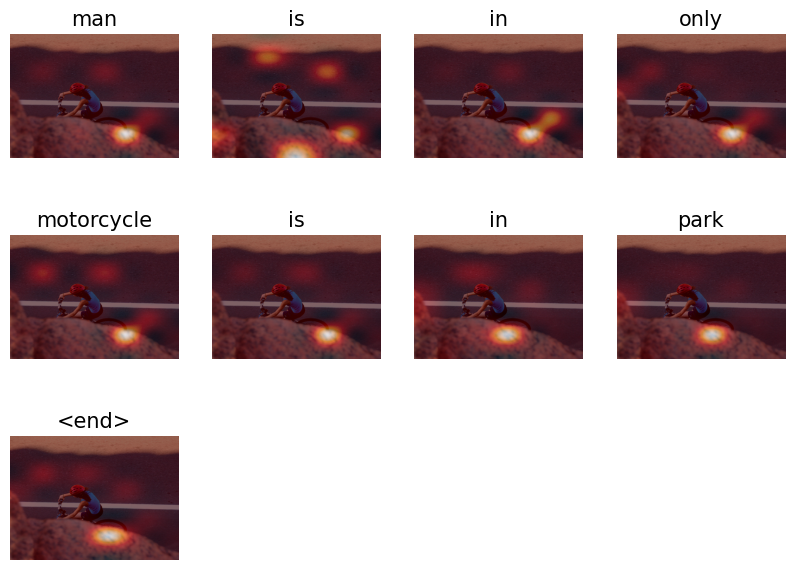

In [ ]:
test_caption_generation(test_image)

Real Caption: A girl is riding a bike on the street while wearing a red helmet .
Prediction Caption: man with red orange clothes and helmet <end>

BELU score: 
5.3701405702879534e-232




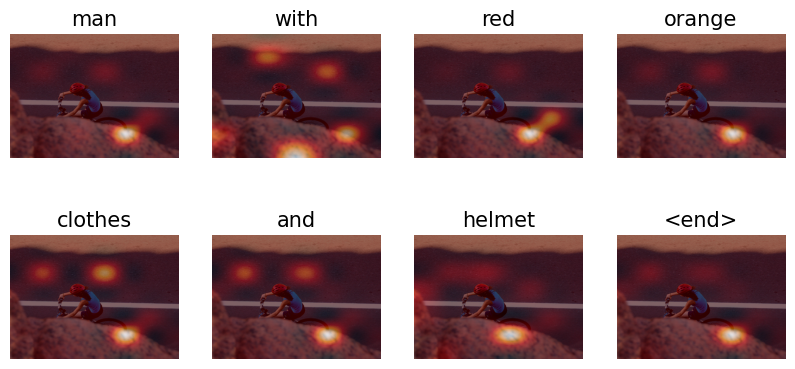

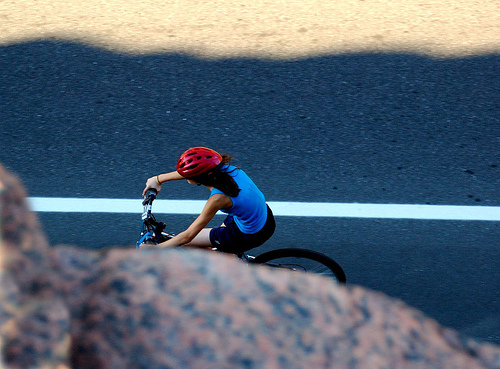

In [ ]:
real_caption = 'A girl is riding a bike on the street while wearing a red helmet .'
result, attention_plot, pred_test = evaluate('/Users/username/Desktop/flickr/Flickr8k_Dataset/218342358_1755a9cce1.jpg')

real_caption=filt_text(real_caption)
pred_caption=' '.join(result)

real_appn = [real_caption.split()]
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)

score = sentence_bleu(reference, candidate)
print("\nBELU score: ")
print(score)
print("\n")

plot_attmap(result, attention_plot, test_image)
Image.open(test_image)

In [ ]:
test_image4='/Users/username/Desktop/flickr/Flickr8k_Dataset/3234115903_f4dfc8fc75.jpg'

Real Caption: A female hockey player in blue is challenging the player in white for the ball.
Prediction Caption: the boy in shorts and red shorts drives in front of hockey with young boy in athletic shorts <end>

BELU score: 
1.2340561512781763e-231




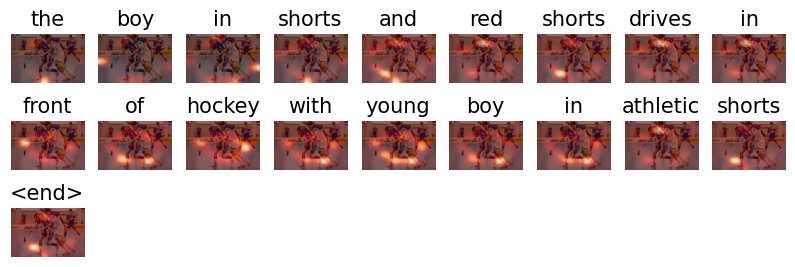

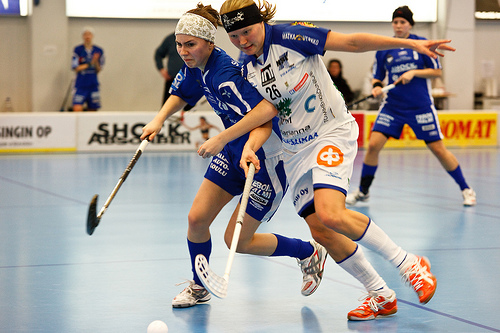

In [ ]:
real_caption = 'A female hockey player in blue is challenging the player in white for the ball.'
result, attention_plot, pred_test = evaluate(test_image4)


real_caption=filt_text(real_caption)
pred_caption=' '.join(result)

real_appn = [real_caption.split()]
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)

score = sentence_bleu(reference, candidate)
print("\nBELU score: ")
print(score)
print("\n")

plot_attmap(result, attention_plot, test_image4)
Image.open(test_image4)

In [ ]:
test_image5='/Users/username/Desktop/flickr/Flickr8k_Dataset/2339140905_9f625f140a.jpg'

Real Caption: A woman in a yellow jacket skis in the snow.
Prediction Caption: woman wearing yellow jacket traversing down the with his skis down the snow <end>

BELU score: 
6.072910347203158e-155




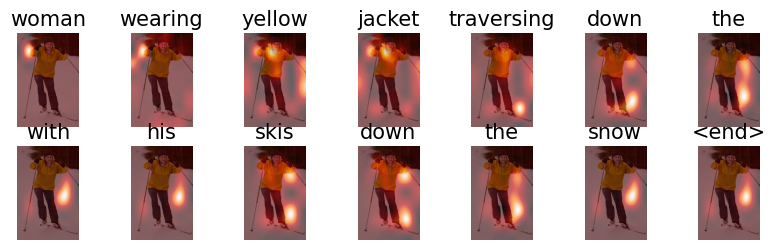

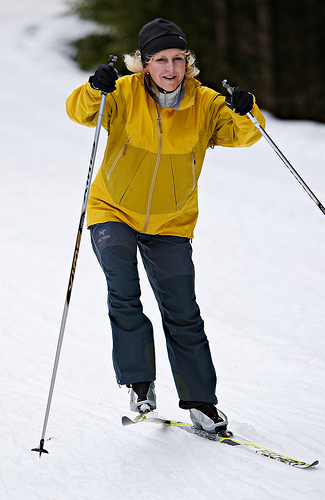

In [ ]:
real_caption = 'A woman in a yellow jacket skis in the snow.'
result, attention_plot, pred_test = evaluate(test_image5)

real_caption=filt_text(real_caption)
pred_caption=' '.join(result)

real_appn = [real_caption.split()]
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)


score = sentence_bleu(reference, candidate)
print("\nBELU score: ")
print(score)
print("\n")

plot_attmap(result, attention_plot, test_image5)
Image.open(test_image5)

In [ ]:
test_image6='/Users/username/Desktop/flickr/Flickr8k_Dataset/2623930900_b9df917b82.jpg'

Real Caption: A man who has a gray beard and gray hair laughs while wearing a purple shirt .
Prediction Caption: man wearing green velvet earpiece <end>

BELU score: 
2.213204067596096e-232




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-

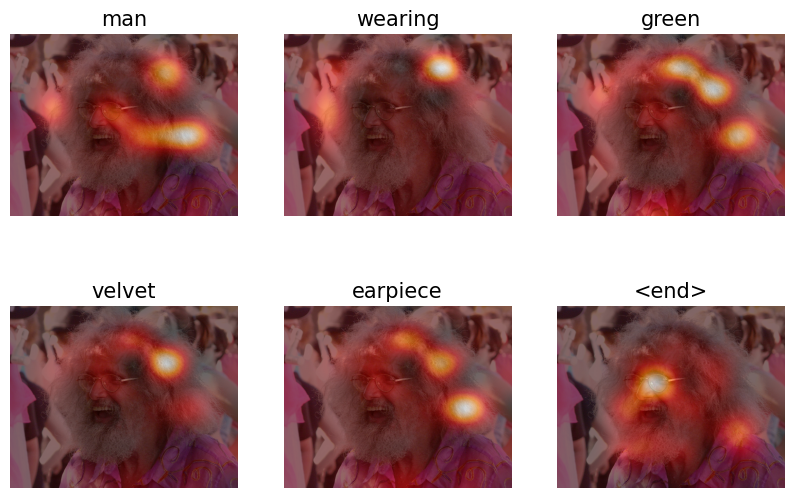

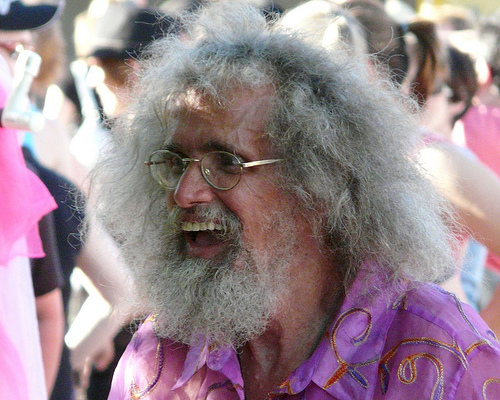

In [ ]:
real_caption = 'A man who has a gray beard and gray hair laughs while wearing a purple shirt .'
result, attention_plot, pred_test = evaluate(test_image6)

real_caption=filt_text(real_caption)
pred_caption=' '.join(result)
real_appn = [real_caption.split()]
reference = real_appn
candidate = pred_caption.split()
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
score = sentence_bleu(reference, candidate)
print("\nBELU score: ")
print(score)
print("\n")

plot_attmap(result, attention_plot, test_image6)
Image.open(test_image6)

In [ ]:
test_image7='/Users/username/Desktop/flickr/Flickr8k_Dataset/3430607596_7e4f74e3ff.jpg'

Real Caption: A boy in a red swimsuit jumps into the water to join two people .
Prediction Caption: man is going through the water <end>

BELU score: 
2.22218822123632e-155




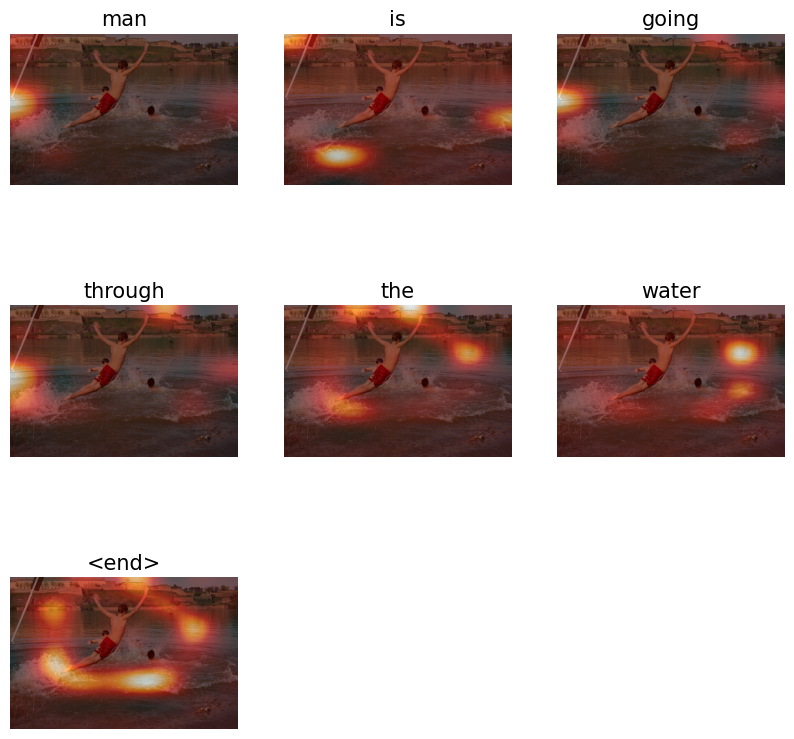

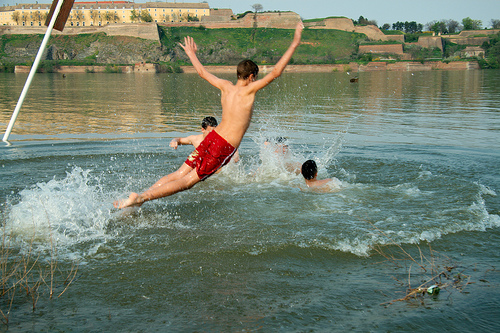

In [ ]:
real_caption = 'A boy in a red swimsuit jumps into the water to join two people .'
result, attention_plot, pred_test = evaluate(test_image7)
real_caption=filt_text(real_caption)
pred_caption=' '.join(result)
real_appn = [real_caption.split()]
reference = real_appn
candidate = pred_caption.split()
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
score = sentence_bleu(reference, candidate)
print("\nBELU score: ")
print(score)
print("\n")

plot_attmap(result, attention_plot, test_image7)
Image.open(test_image7)

In [ ]:
########

In [ ]:
def pred_caption(image):
    result, _, _ = evaluate(image)
    pred_caption = ' '.join(result)
    return pred_caption

In [ ]:
def read_file(file_name, text_dir):
    with open(os.path.join(text_dir, file_name), 'r', encoding='UTF-8') as files:
        lines = files.read().splitlines()
    return lines

## generate caption

In [ ]:
input_testpath=[]
generate_caption=[]

In [ ]:
for itm in test_image_paths:
    input_testpath.append(itm)
    out=pred_caption('/Users/username/Desktop/flickr/Flickr8k_Dataset/'+itm)
    generate_caption.append(out)

In [ ]:
with open("/Users/username/Desktop/output_att/caption_output.csv", "w") as infile:
    writer = csv.writer(infile)
    writer.writerow(["image", "caption"])
    for i in zip(input_testpath, generate_caption):
        writer.writerow(i)

## evaluation - BLEU

In [ ]:
##########

In [ ]:
candidate_corpus=[]
reference_corpus=[]

In [ ]:
col_one_list = test_captions_df['caption'][::5].tolist()

In [ ]:
for word in col_one_list:
    reference_corpus.append([word.split()[:-1]])

In [ ]:
for word in generate_caption:
    candidate_corpus.append(word.split()[:-1])

In [ ]:
print(bleu_score(candidate_corpus, reference_corpus))

0.41148827720319253


## evaluation - bias

In [ ]:
data_set = '/Users/username/Desktop/flickr/'
captions_dir = data_set + "Flickr8k_text/"
train_images = captions_dir + 'Flickr_8k.trainImages.txt'
test_images = captions_dir + 'Flickr_8k.testImages.txt'

In [ ]:
def load_all_captions(file_name):
    text_file = open(file_name, "r")
    lines = text_file.readlines()
    data_set = []
    for l in range(len(lines)):
        line = lines[l].strip()
        image_name = line[:line.find("#")]
        caption_number = line[line.find("#")+1:line.find("#")+2]
        caption = line[line.find("\t")+1:]
        data_set.append([image_name, caption_number, caption])
    return pd.DataFrame(data_set, columns =['image', 'caption#', 'caption'])

In [ ]:
captions_df = load_all_captions(captions_dir + "Flickr8k.token.txt")

In [ ]:
def load_test_image(file_name):
    text_file = open(file_name, "r")
    lines = text_file.readlines()
    data_set = []
    for l in range(len(lines)):
        line = lines[l].strip()
        data_set.append(line)
    return pd.DataFrame(data_set, columns =['image'])

In [ ]:
test_df = load_test_image(test_images)

In [ ]:
def get_ground_captions(test_df, captions_df):
    new_df = pd.DataFrame(columns = ['image', 'caption'])
    for i in tqdm(test_df.index):
        temp = captions_df[captions_df['image']==test_df.iloc[i]['image']]
        for j in range(5):
            new_df = pd.concat([new_df, pd.DataFrame([{'image': test_df.iloc[i]['image'], 'caption': temp.iloc[j]['caption']}])], ignore_index=True)
    return new_df

In [ ]:
test_captions_df = get_ground_captions(test_df, captions_df)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
pred_df = pd.read_csv('/Users/username/Desktop/output_att/caption_output.csv')

In [ ]:
df_repeat = pred_df.loc[pred_df.index.repeat(5)]

In [ ]:
def idetify_gender(sentence):
    male_words = ["male", "man", "boy", "gentleman", "guy", "dude","boys","men"]
    female_words = ["female","woman", "girl", "lady", "girls", "women"]
    male = False
    female = False
    for male_word in male_words:
        if sentence.find(male_word) > 0:
            male = True
    for female_word in female_words:
        if sentence.find(female_word) > 0:
            female = True
    if male and not female:
        return "male"
    elif female and not male:
        return "female"
    return "other"

In [ ]:
def gender_error(ground_truth, predicted):
    ground_truth_gender = ground_truth['caption'].apply(lambda x: idetify_gender(x))
    predicted_gender = predicted['caption'].apply(lambda x: idetify_gender(x))
    return confusion_matrix(ground_truth_gender, predicted_gender, labels=["male", "female", "other"])

In [ ]:
def gender_ratio(ground_truth, predicted):
    ground_truth_gender = ground_truth['caption'].apply(lambda x: idetify_gender(x))
    predicted_gender = predicted['caption'].apply(lambda x: idetify_gender(x))
    ground_truth_ratio = ground_truth_gender.value_counts()["female"]/ground_truth_gender.value_counts()["male"]
    predicted_ratio = predicted_gender.value_counts()["female"]/predicted_gender.value_counts()["male"]
    return (ground_truth_ratio, predicted_ratio)

In [ ]:
def object_gender_cooccurrence(ground_truth, predicted, object_name):
    gt_male_co = ground_truth['caption'].apply(lambda x: True if (idetify_gender(x)=="male" and x.find(object_name)>0) else False)
    gt_female_co =  ground_truth['caption'].apply(lambda x: True if (idetify_gender(x)=="female" and x.find(object_name)>0) else False)
    m1 = gt_male_co.value_counts()[True] if True in gt_male_co.value_counts() else 0
    f1 = gt_female_co.value_counts()[True] if True in gt_female_co.value_counts() else 0
    gt = (m1, f1)

    pred_male_co = predicted['caption'].apply(lambda x: True if (idetify_gender(x)=="male" and x.find(object_name)>0) else False)
    pred_female_co =  predicted['caption'].apply(lambda x: True if (idetify_gender(x)=="female" and x.find(object_name)>0) else False)
    m2 = pred_male_co.value_counts()[True] if True in pred_male_co.value_counts() else 0
    f2 = pred_female_co.value_counts()[True] if True in pred_female_co.value_counts() else 0
    pred = (m2, f2)

    return (gt, pred)

In [ ]:
def experiment(df, pred_df):

    cf_matrix = gender_error(df, pred_df)
    plt.figure(figsize = (7,5))
    ax = sns.heatmap(cf_matrix, annot=True, xticklabels = ["male", "female", "other"], yticklabels = ["male", "female", "other"])
    ax.set(title="Gender ratio",
      xlabel="Predicted",
      ylabel="Ground truth")
    plt.show()

    print("\n")

    gt, pred = gender_ratio(df, pred_df)
    print("Gender ratio of female to male:")
    print("Ground truth captions-> " + str(gt))
    print("Predicted captions->    " + str(pred))

    print("\n")

    words = ["bike"]
    for word in words:
        gt, pred = object_gender_cooccurrence(df, pred_df, word)
        X = ["male", "female"]
        X_axis = np.arange(2)

        plt.bar(X_axis - 0.2, gt, 0.4, label = 'Ground truth')
        plt.bar(X_axis + 0.2, pred, 0.4, label = 'Predicted')

        plt.xticks(X_axis, X)
        plt.xlabel("Gender")
        plt.ylabel("co-occurrence with target word: \"" + word + "\"")
        plt.title("co-occurrence with \"" + word + "\" and male & female words")
        plt.legend()
        plt.show()

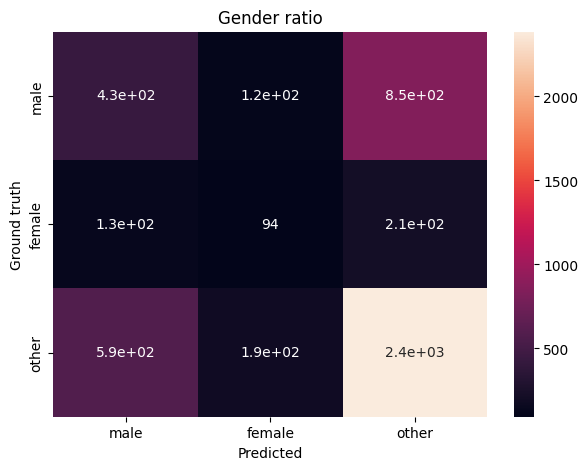



Gender ratio of female to male:
Ground truth captions-> 0.31379556826304505
Predicted captions->    0.3521739130434783




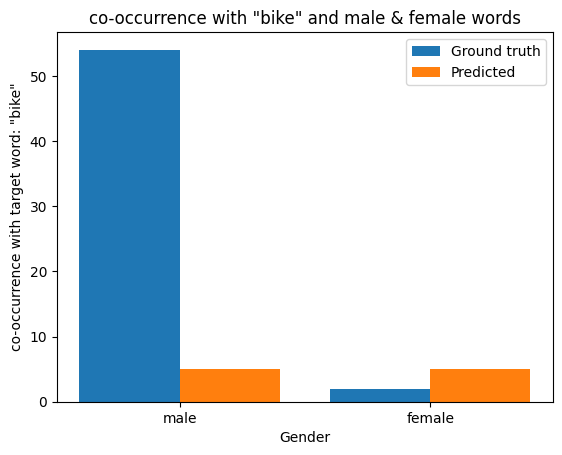

In [ ]:
experiment(test_captions_df, df_repeat)

In [ ]:
def test_experiment(df, pred_df):
    words = ["basketball", "soccer", "snowboard"]
    for word in words:
        gt, pred = object_gender_cooccurrence(df, pred_df, word)
        X = ["male", "female"]
        X_axis = np.arange(2)
        plt.bar(X_axis - 0.2, gt, 0.4, label = 'Ground truth')
        plt.bar(X_axis + 0.2, pred, 0.4, label = 'Predicted')
        plt.xticks(X_axis, X)
        plt.xlabel("Gender")
        plt.ylabel("co-occurrence with target word: \"" + word + "\"")
        plt.title("co-occurrence with \"" + word + "\" and male & female words")
        plt.legend()
        plt.show()

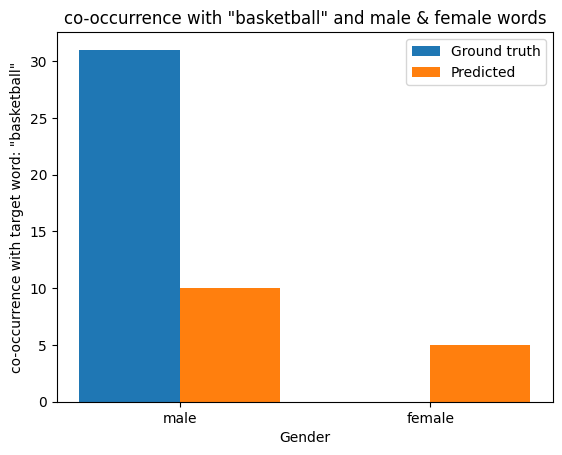

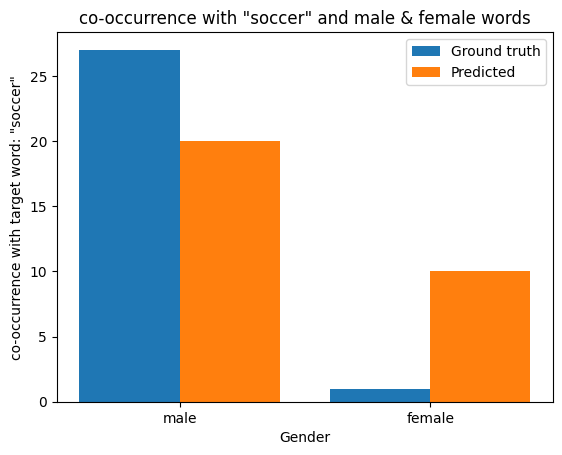

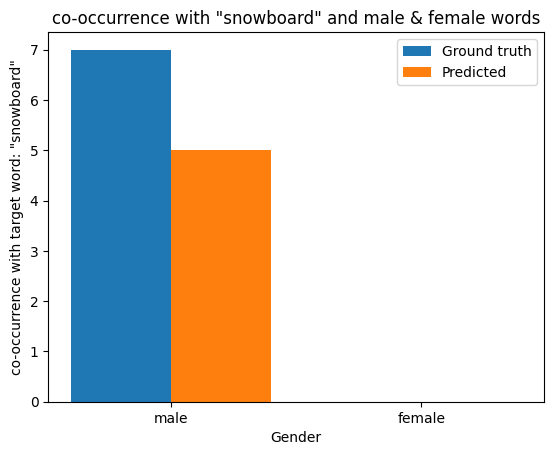

In [ ]:
test_experiment(test_captions_df, df_repeat)